In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels as smt
import scipy.stats as scs
import warnings
import yfinance as yf
from arch import arch_model
from datetime import datetime
from pandas.tseries.offsets import BDay
from matplotlib.gridspec import GridSpec

warnings.filterwarnings('ignore')

# Stationary
1. Constant mean
2. Constant variance
3. Covariance of ith and i+mth is not a function of time

# White Noise
- QQ Plot => Quantiles of two variables are plotted against each other, by deufalt, the other random variables is normally distributed. If it follows the straight line, then likely they are the same distribution

## Few conclusions
- white noise are normally distributed based on QQ plot
- white noise has no serial correlation, based on acf/pacf plot

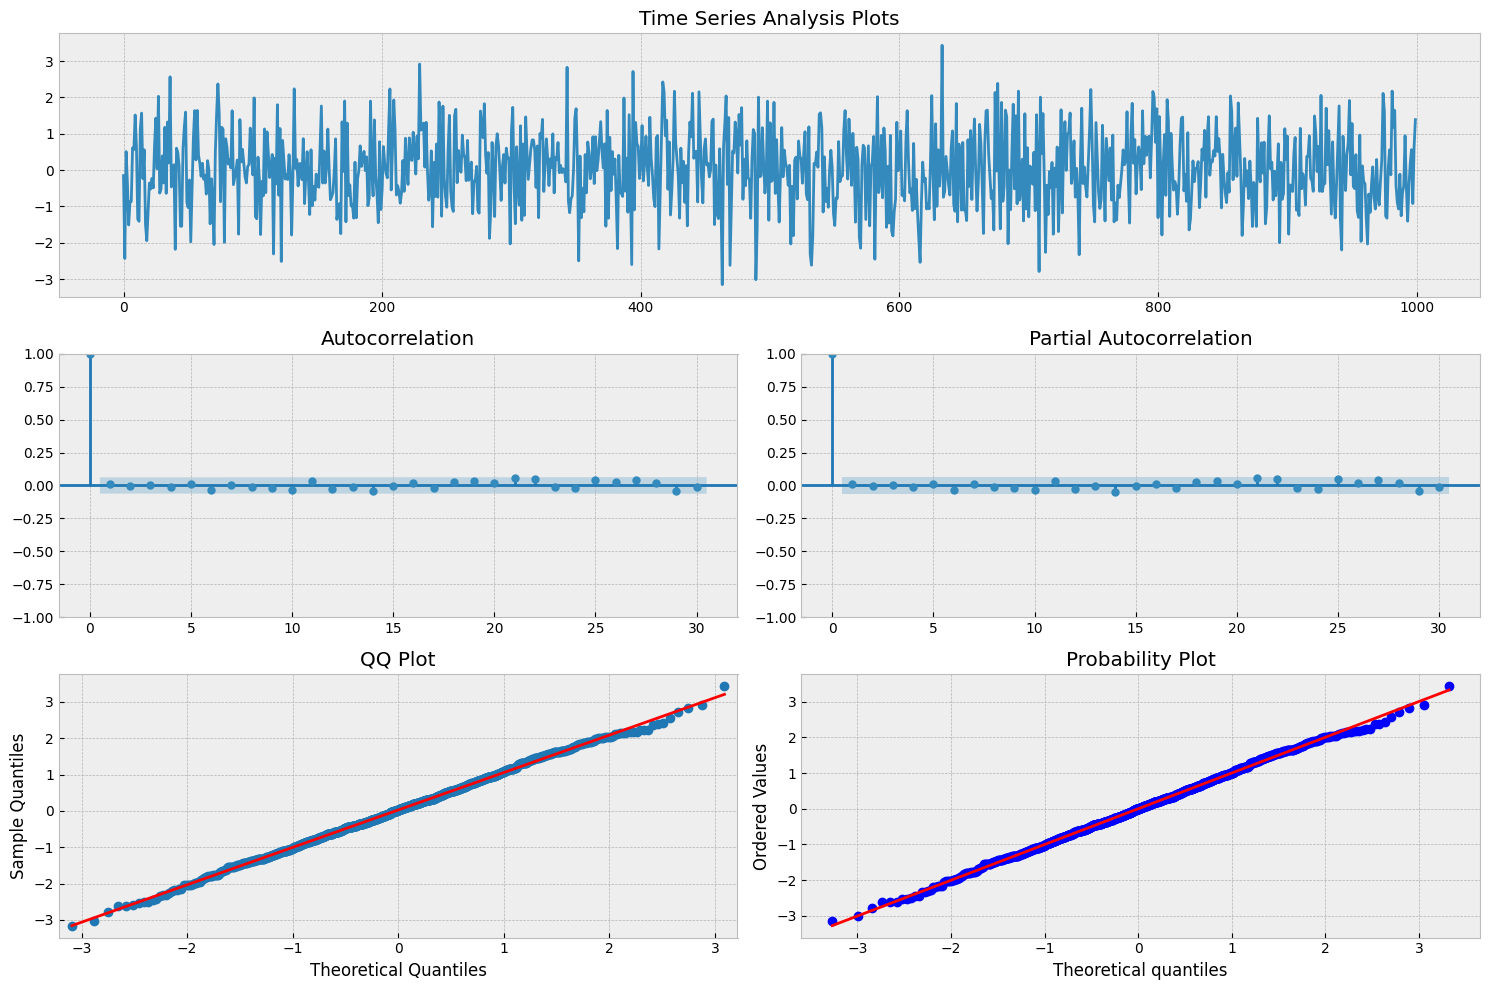

In [32]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)        
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
                
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')        
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()            

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)
plt.show()

# Random Walk
A random walk is a time series model where the value of the time series variable increases or decreases (step up or down) with equal probability at each time step
$$x_t=x_{t-1}+w_t$$
where $w_t$ is discrete white noise
$$E[x_t]=x_{t-1}$$

Random walk is non-stationary, because the covariance is time-dependent

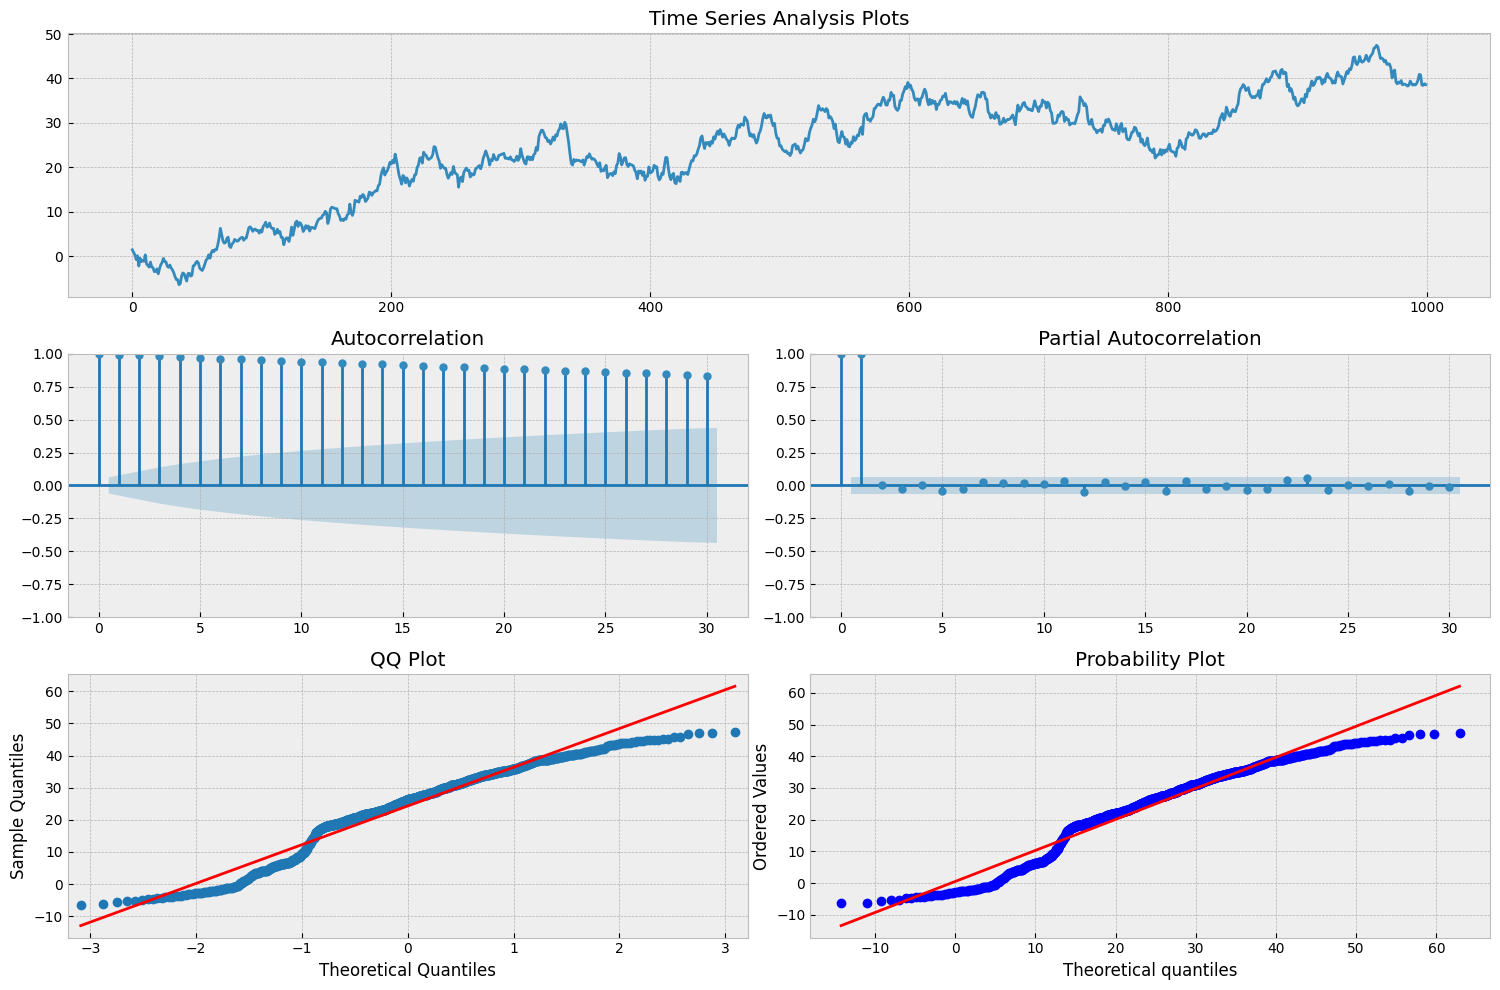

In [34]:
# Random Walk without a drift
np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

tsplot(x, lags=30)
plt.show()

### If we plot first-order difference of SPX, it looks like white noise which is stationary

[*********************100%***********************]  1 of 1 completed


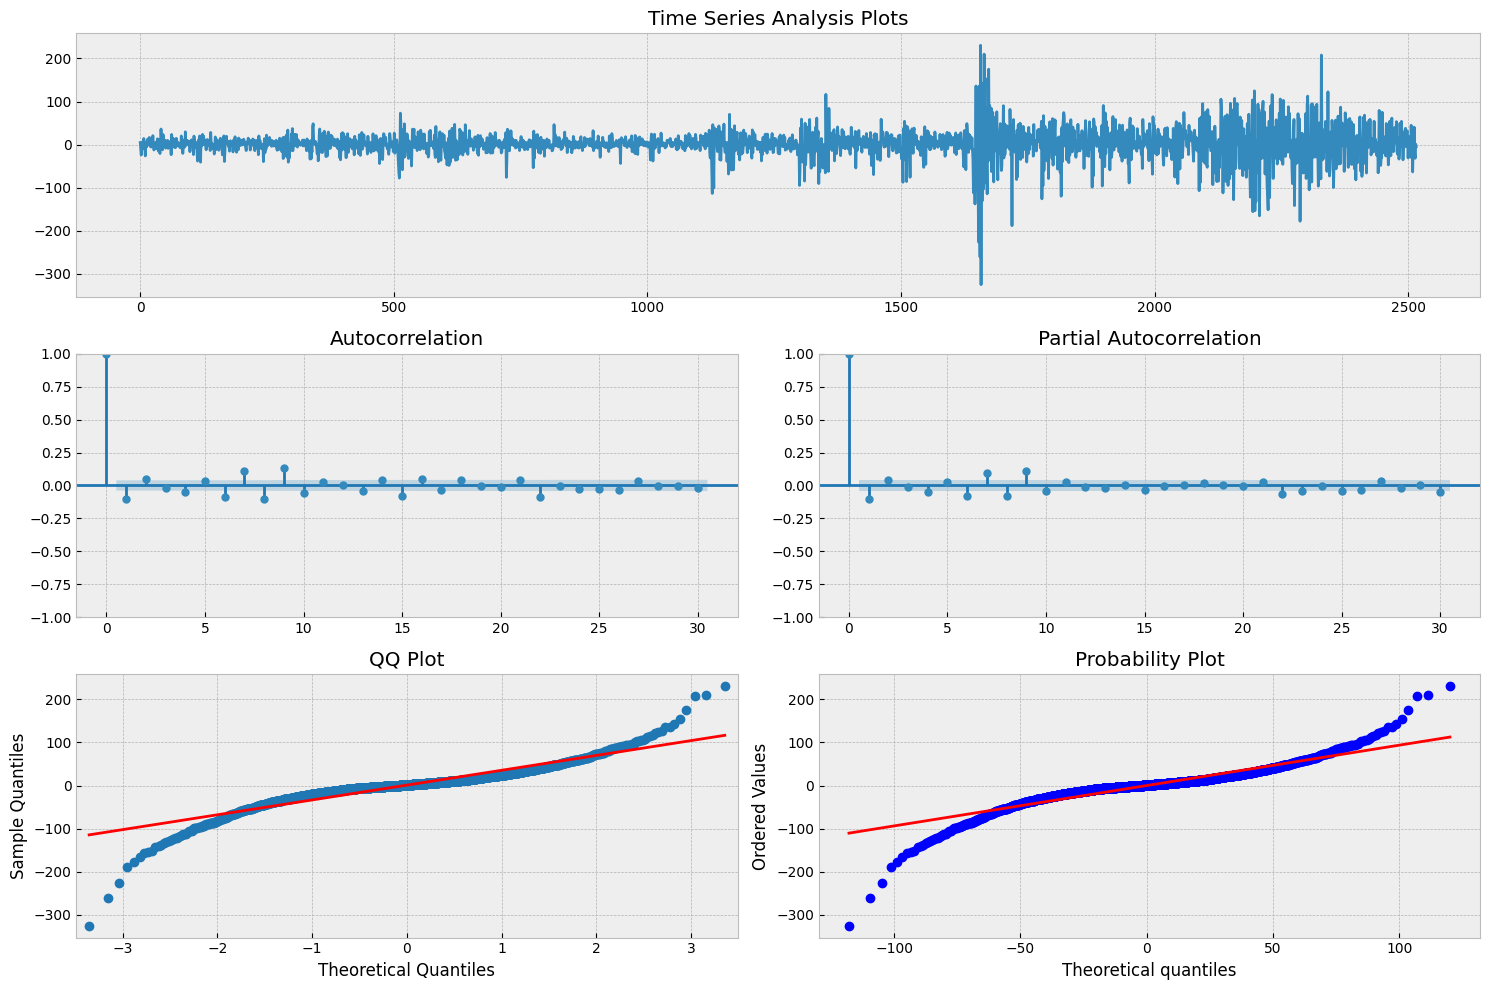

In [43]:
df = yf.download(tickers=["^GSPC"],period="10y",interval="1d",auto_adjust=True).reset_index()
x = df['Close'].values
x = np.diff(x)
tsplot(x, lags=30)
plt.show()

# Autoregressive model
$$AR(p) = x_t = \alpha_1x_{t-1}+......+\alpha_px_{t-p}$$

One of the most important aspects of the AR(p) model is that it is not always stationary. The stationarity of a particular model depends upon the parameters.

<b>Our aim is to find a model fit for our time series such that the residuals are white noise.</b>

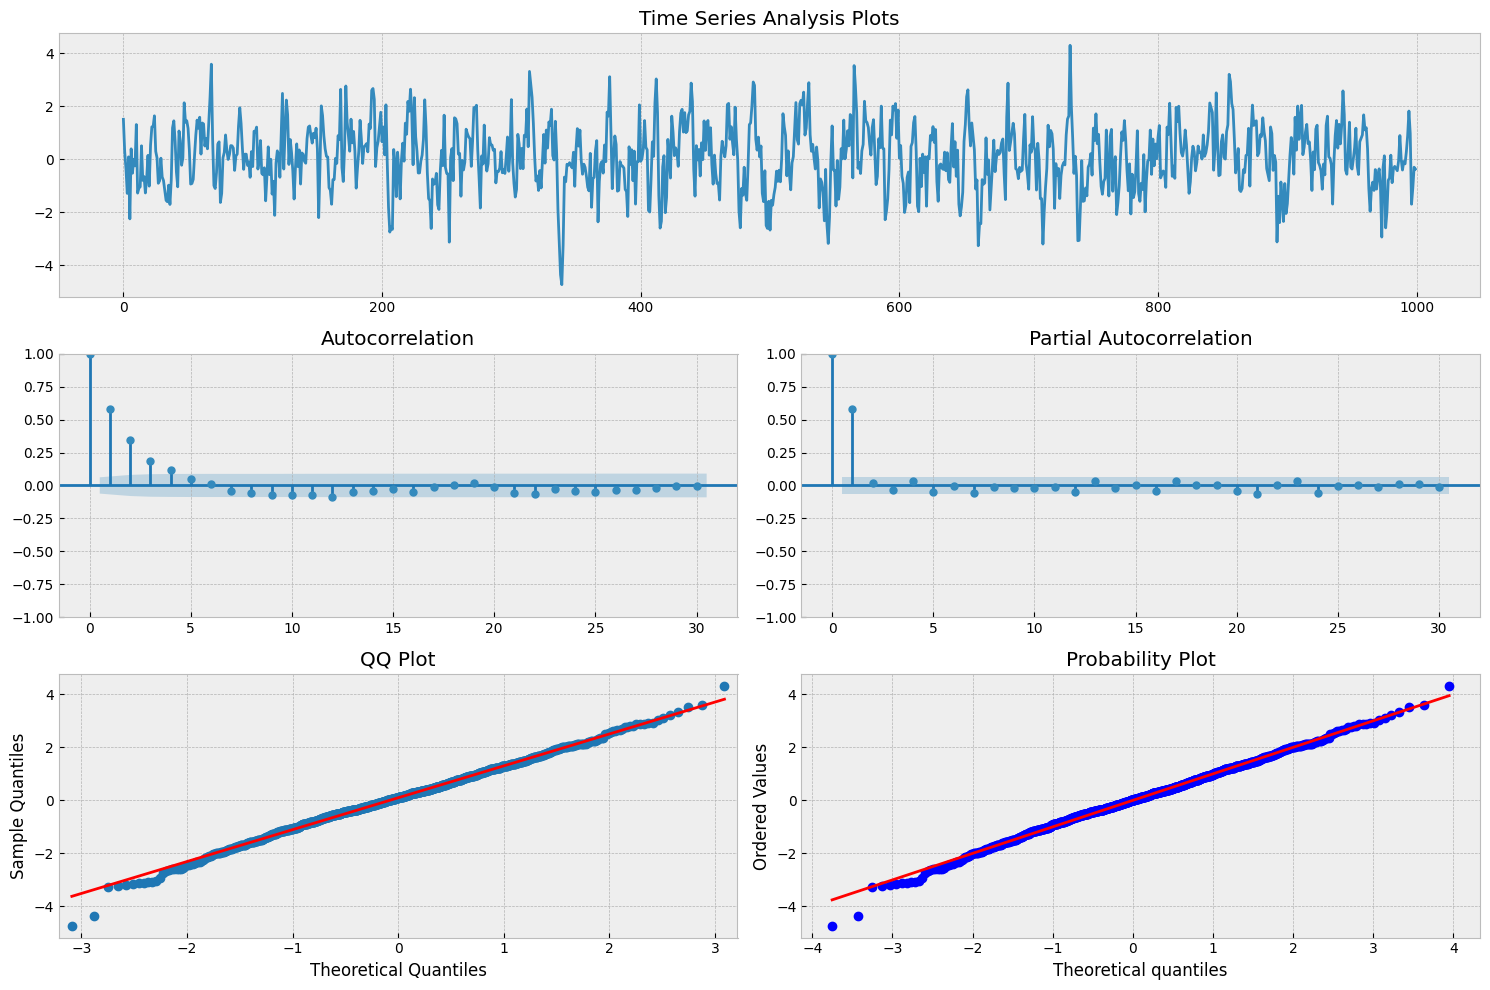

In [46]:
# Simulate an AR(1) process with a = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)
plt.show()

# Moving Average Models

$$x_t = \omega_t+\beta_1\omega_{t-1}+......+\beta_q\omega_{t-q}$$

Where $\omega_t$ is white noise with $E(\omega_t)=0$ and variance $\sigma^2$ 



MA(q) model is a linear combination of past error terms as opposed to a linear combination of past observations like the AR(p) model. The motivation for the MA model is that we can explain "shocks" in the error process directly by fitting a model to the error terms

# GARCH Models

$$\sigma_t^2 = \omega + \sum_{i=1}^{p}\alpha_i\epsilon_{t-i}^2 + \sum_{i=1}^{1} \beta_i\sigma^2_{t-i}$$

where
- $\epsilon_{t-i}$ is the residual from the mean models (could be zero mean / constant mean / or any ARIMA models)
- $\sigma_{t-i}$ is the conditional variance from last periods

Basically GARCH(p,q) models estimate the conditional variance by looking at the past residuals and variance

<b>Empirical study has shown that GARCH(1,1) is fairly good enough</b>

In [106]:
# using SPX as an exmaples
last_obs = datetime.today() - BDay(60)

spx = yf.download(tickers='^SPX',period="3y",interval="1d",auto_adjust=True)
spx = spx[['Close']]
spx['Return'] = spx['Close'].pct_change().fillna(0) * 100
am = arch_model(spx['Return'], vol='GARCH', p=1, q=1, dist='skewt')
res = am.fit(disp='off', last_obs=last_obs)
forecasts = res.forecast(start=last_obs+BDay(1), reindex=False)

[*********************100%***********************]  1 of 1 completed


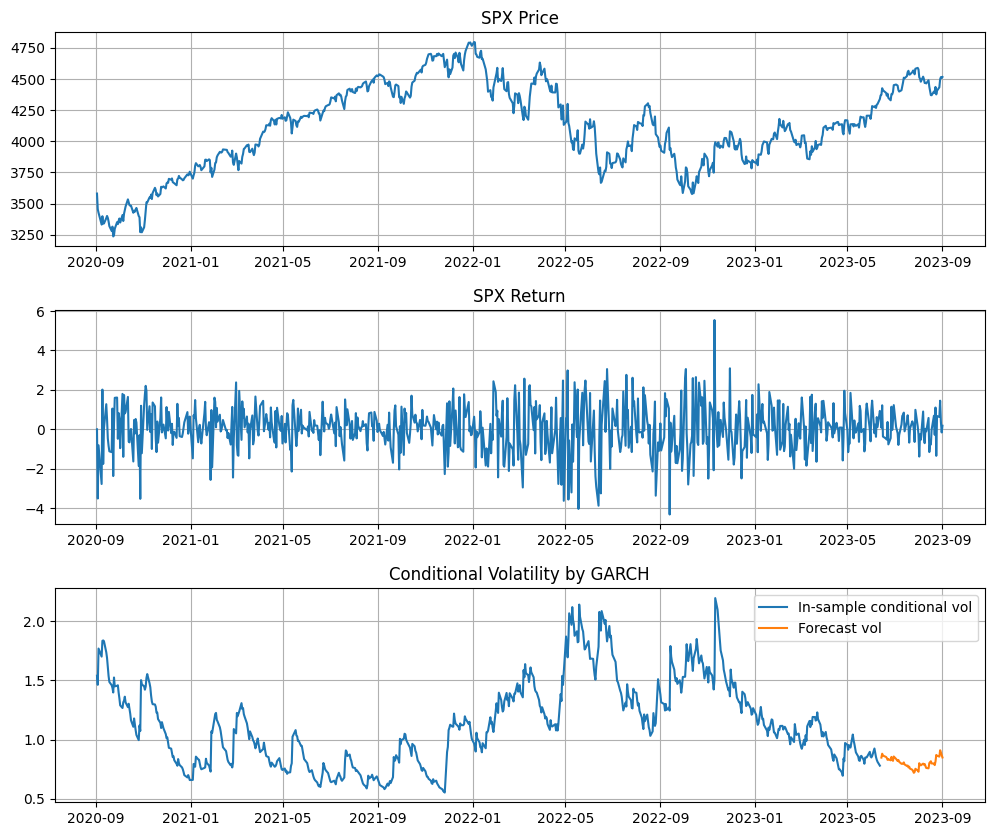

In [107]:
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.3)
gs = GridSpec(3,1)

ax = fig.add_subplot(gs[0])
ax.plot(spx['Close'])
ax.grid()
ax.set_title('SPX Price')

ax = fig.add_subplot(gs[1])
ax.plot(spx['Return'])
ax.grid()
ax.set_title('SPX Return')

ax = fig.add_subplot(gs[2])
ax.plot(res.conditional_volatility, label="In-sample conditional vol")
ax.plot(cond_vol, label='Forecast vol')
ax.grid()
ax.legend()
ax.set_title('Conditional Volatility by GARCH')
plt.show()

## Value at Risk

#### Estimate the 1% and 5% value of the SPX returns using GARCH model above

- GARCH: VaR ∼ conditional mean, the conditional volatility and the quantile of the standardized residuals

$$VaR_{t-1|t} = \mu_{t+1|t} - \sigma_{t+1|t}q_q$$

<i>Each dot represents daily SPX returns</i>

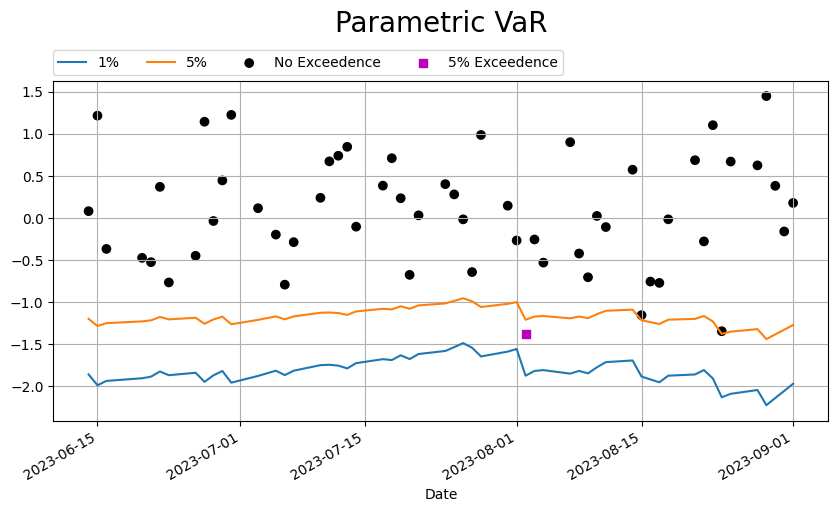

In [108]:
cond_mean = forecasts.mean
cond_var = forecasts.variance
cond_vol = np.sqrt(cond_var)
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])

value_at_risk = (cond_mean.values + np.sqrt(cond_var).values * q[None, :])
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
value_at_risk.plot(legend=False, ax=ax)

rets_2018 = spx[last_obs+BDay(1):].copy()['Return']
rets_2018.name = "S&P 500 Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > value_at_risk.loc[idx, "5%"]:        
        c.append("#000000")
    elif rets_2018[idx] < value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {"#BB0000": "1% Exceedence", "#BB00BB": "5% Exceedence", "#000000": "No Exceedence",}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR", pad=35, fontsize=20)
ax.legend(ncol=5, loc='upper left', bbox_to_anchor=(-0.01,1.11))
ax.grid()